In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
layers, models, optimizers = tf.keras.layers, tf.keras.models, tf.keras.optimizers
EarlyStopping = tf.keras.callbacks.EarlyStopping
import matplotlib.pyplot as plt

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-26 10:07:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-26 10:07:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-26 10:07:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [12]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [14]:
data = pd.read_csv('data (1).csv')
sentences = data['text'].str.lower().tolist()
labels = data['label'].tolist()
stopword = [
    "yang", "dan", "di", "ke", "dari", "untuk", "dengan", "pada", "adalah",
    "ini", "itu", "saya", "kita", "anda", "akan", "telah", "sebagai", "atau",
    "jadi", "karena", "tidak", "dalam", "lebih", "lagi", "hanya", "sudah", "juga"
]



In [15]:
processed_sentences = []
for sentence in sentences:
    for word in stopword:
        sentence = sentence.replace(f" {word} ", " ")  # Remove stopwords
    processed_sentences.append(sentence.strip())

In [16]:
train_size = int(len(processed_sentences) * 0.8)

train_sentences = processed_sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences =processed_sentences[train_size:]
validation_labels = labels[train_size:]

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [18]:
training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

In [21]:
glove_file = 'glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [23]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [24]:
model = models.Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='softmax')
    ])

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
early_stop = EarlyStopping(monitor='val_accuracy',
                            patience=2,
                            verbose=1,
                            restore_best_weights=True,
                            min_delta=0.01,
                            mode='max',  # 'max' will stop when accuracy reaches a maximum
                            baseline=0.94)

In [27]:
history = model.fit(train_padded, training_label_seq,
                    epochs=10,
                    validation_data=(validation_padded, validation_label_seq),
                    callbacks=[early_stop])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 948ms/step - accuracy: 0.3085 - loss: 1.7599 - val_accuracy: 0.8125 - val_loss: 0.5376
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 867ms/step - accuracy: 0.8838 - loss: 0.3769 - val_accuracy: 0.9413 - val_loss: 0.2703
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9628 - loss: 0.1380 - val_accuracy: 0.9337 - val_loss: 0.2676
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.


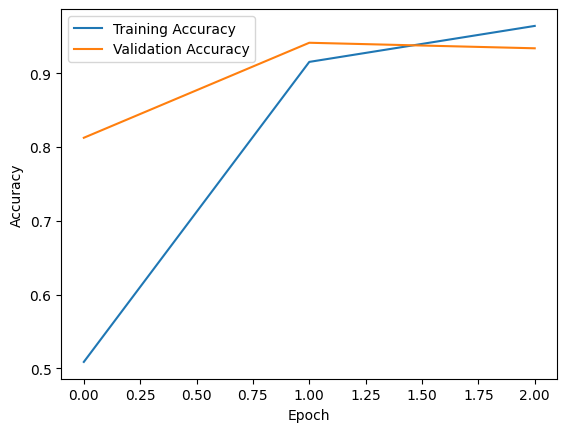

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
def predict_sentiment(text, tokenizer, model, max_length, padding_type, trunc_type):

    # Preprocess the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    prediction = model.predict(padded_sequence)
    predicted_label_index = np.argmax(prediction[0]) # Get the index of the highest probability
    sentiment_labels = ['anticipation','anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
    predicted_sentiment = sentiment_labels[predicted_label_index]

    return predicted_sentiment

In [37]:
new_text = "kemarin aku terkejut saat melihat gunung berapi meledak"

predicted_sentiment = predict_sentiment(new_text, tokenizer, model, max_length, padding_type, trunc_type)

print(f"Predicted sentiment for '{new_text}': {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted sentiment for 'kemarin aku terkejut saat melihat gunung berapi meledak': surprise
